In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pybullet
from robot_descriptions.loaders.pybullet import load_robot_description
import time

### Initial configuration

In [2]:
INITIAL_CONF = [-0.07195958737978714, -0.031165154579558596, -1.804251465569389, -1.4883759445410973, 0.11663409459107088, -2.914561838332981]

In [3]:
pybullet.connect(pybullet.GUI)
name = 'ur5_description'
robot = load_robot_description(name)

In [4]:
pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_SHADOWS, 0)
pybullet.configureDebugVisualizer(pybullet.COV_ENABLE_GUI, 0)
pybullet.setGravity(0,0,-9.8)

In [5]:
nq = pybullet.getNumJoints(robot)

In [8]:
for joint in range(nq):
    info = pybullet.getJointInfo(robot, joint)
    # print(info)

In [9]:
free_joints = []
for i in range(nq):
   if pybullet.getJointInfo(robot, i)[2] != 4:
       free_joints.append(i)

In [10]:
timeStep = 1./300
pybullet.setTimeStep(timeStep)

for j in free_joints:
	pybullet.setJointMotorControl2(robot, j, pybullet.VELOCITY_CONTROL, force=0)

free_joints = free_joints[:6]

### Make arm movement

In [11]:
def linear_interpolate_path(start_pos, delta_xyz, interval):
    """
    Plots steps of length 'interval' from 'start_pos' to 'start_pos'+'delta_xyz'
    """
    start_pos = np.array(start_pos).flatten()
    delta_xyz = np.array(delta_xyz).flatten()
    path_len = np.linalg.norm(delta_xyz)
    num_pts = int(np.ceil(path_len / float(interval)))
    if num_pts <= 1:
        num_pts = 2
    waypoints_sp = np.linspace(0, path_len, num_pts).reshape(-1, 1)
    waypoints = start_pos + waypoints_sp / float(path_len) * delta_xyz
    return waypoints

In [12]:
def get_ee_pose():
    info = pybullet.getLinkState(robot, ee_link_id)
    pos = info[4]
    quat = info[5]
    return np.array(pos), np.array(quat)

In [13]:
def to_quat(ori):
    """
    Converts the input rotation format to unit quaternion
    """
    ori = np.array(ori)
    if ori.size == 3:
        # [roll, pitch, yaw]
        ori = euler2quat(ori)
    elif ori.shape == (3, 3):
        ori = rot2quat(ori)
    elif ori.size != 4:
        raise ValueError('Orientation should be rotation matrix, '
                         'euler angles or quaternion')
    return ori

In [14]:
def ang_in_mpi_ppi(angle):
    """
    Restricts the angle within the range [-pi, pi)
    """
    angle = (angle + np.pi) % (2 * np.pi) - np.pi
    return angle

In [15]:
def compute_inverse_kinematics(pos, ori):
    ori = to_quat(ori)
    jnt_poss = pybullet.calculateInverseKinematics(robot, ee_link_id, pos, ori)
    jnt_poss = list(map(ang_in_mpi_ppi, jnt_poss))
    arm_jnt_poss = [jnt_poss[i] for i in range(len(free_joints))]
    return arm_jnt_poss

In [16]:
def set_jpos(position, log=False):
    position = position.copy()
    tgt_pos = position
    pybullet.setJointMotorControlArray(robot, free_joints, pybullet.POSITION_CONTROL, targetPositions=tgt_pos)
    pybullet.stepSimulation()
    if log:
        ee_positions_x.append(pybullet.getLinkState(robot, ee_link_id)[0][0])
        ee_positions_y.append(pybullet.getLinkState(robot, ee_link_id)[0][1])
        ee_positions_z.append(pybullet.getLinkState(robot, ee_link_id)[0][2])

    time.sleep(timeStep)

#### Send Robot to Desired Initial Position

In [17]:
for i in range(100):
    set_jpos(INITIAL_CONF)

#### Take Small Steps to Reach Destination Position

In [18]:
ee_link_id = 7 # Check
delta_xyz = np.array((-1,0,0)) #oscillate between (1,0,0) and (-1,0,0)
eef_step = 0.02
pybullet.setRealTimeSimulation(0)

ee_positions_x = []
ee_positions_y = []
ee_positions_z = []
log_p = []
log_theta = []

pos, quat = get_ee_pose()
cur_pos = np.array(pos)
delta_xyz = np.array(delta_xyz)

waypoints = linear_interpolate_path(cur_pos, delta_xyz, eef_step)
way_jnt_positions = []
for i in range(waypoints.shape[0]):
    tgt_jnt_poss = compute_inverse_kinematics(waypoints[i, :].flatten().tolist(), quat)
    way_jnt_positions.append(tgt_jnt_poss.copy())
for jnt_poss in way_jnt_positions:
    sub_steps = 4
    for i in range(1, sub_steps):
        set_jpos(jnt_poss, log=False)
    set_jpos(jnt_poss, log=True)

### Plot Ideal vs Actual Positions of End Effector

[]

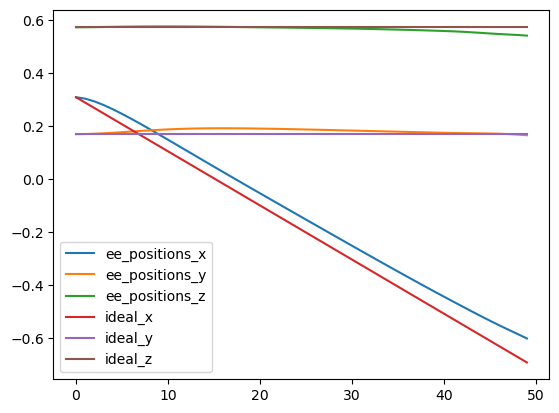

In [19]:
plt.plot(ee_positions_x, label='ee_positions_x')
plt.plot(ee_positions_y, label='ee_positions_y')
plt.plot(ee_positions_z, label='ee_positions_z')

plt.plot(waypoints[:, 0], label='ideal_x')
plt.plot(waypoints[:, 1], label='ideal_y')
plt.plot(waypoints[:, 2], label='ideal_z')

plt.legend()
plt.plot()

In [20]:
pybullet.disconnect()

### Structured Code

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time
from robot_descriptions.loaders.pybullet import load_robot_description
import pybullet

In [2]:
from observation import Actor
actor = Actor()

In [3]:
pybullet.connect(pybullet.GUI)
name = 'ur5_description'
robot = load_robot_description(name)

timeStep = 1./300
pybullet.setTimeStep(timeStep)

In [4]:
pybullet.setGravity(0, 0, -9.8)

In [5]:
for j in actor.free_joints:
    pybullet.setJointMotorControl2(
        robot, j, pybullet.VELOCITY_CONTROL, force=0)

pos, quat = actor.get_ee_pose(robot)

for i in range(100):
    actor.set_jpos(actor.INITIAL_CONF, robot, timeStep)

timeStep = 1./3000
pybullet.setTimeStep(timeStep)
episode, ee_positions_x, ee_positions_y, ee_positions_z = actor.rollout_from_env(
    robot, actor.pid_policy, timeStep)

In [6]:
pybullet.disconnect()

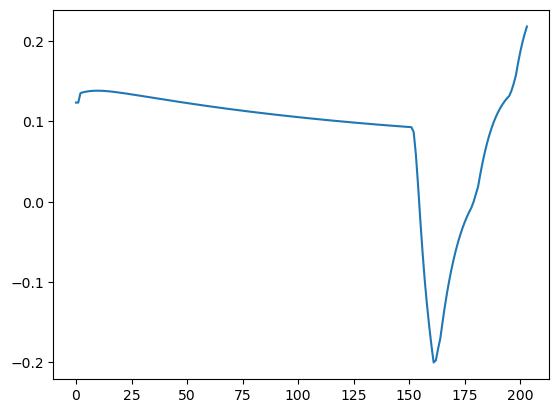

In [7]:
plt.plot(np.array(episode['observation'])[:, 1])